### Подготовка

In [1]:
!wget https://data.deepai.org/PascalVOC2012.zip

--2023-03-30 17:02:44--  https://data.deepai.org/PascalVOC2012.zip
Resolving data.deepai.org (data.deepai.org)... 138.199.9.104, 2400:52e0:1a01::907:1
Connecting to data.deepai.org (data.deepai.org)|138.199.9.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3899239928 (3.6G) [application/zip]
Saving to: ‘PascalVOC2012.zip’

PascalVOC2012.zip   100%[===================>]   3.63G  3.17MB/s    in 17m 28s 

2023-03-30 17:20:12 (3.55 MB/s) - ‘PascalVOC2012.zip’ saved [3899239928/3899239928]



In [2]:
cd /kaggle/working/

/kaggle/working


In [3]:
!ls

PascalVOC2012.zip  __notebook_source__.ipynb


In [5]:
# !unzip PascalVOC2012.zip
# !mv voc2012 VOCdevkit

In [8]:
# !pip install timm

In [9]:
# !pip install pytorch-lightning

In [6]:
%matplotlib inline
import random

import cv2
import torch
import torchvision
import numpy as np
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.datasets import VOCSegmentation

print("Torch", torch.__version__)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    DEVICE="cuda"
    print("Use CUDA")
else:
    DEVICE="cpu"
    
# Параметры тренировки и визуализации.
TRAIN = True  # Если False, будут использоваться заранее посчитанные графики
              # вместо реальной тренировки (полезно для демонстрации на ноутбуках без GPU).

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Torch 1.13.0
Use CUDA


In [7]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "potted_plant", "sheep", "sofa", "train", "tv/monitor"]
MULTICLASS = False  # Если False, отделяем объекты от фона, иначе распознаем класс объектов.
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 2


Mask values: {0, 1, 255}


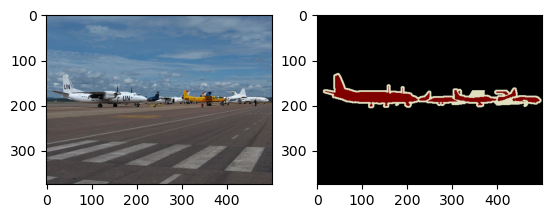

In [8]:
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=False)

image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [9]:
class Scaler(object):

    def __init__(self, size):
        self._size = size
        self._padding = 0
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]
        
        if grayscale:
            result = result[:, :, 0]
        return result

In [10]:
def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask

### Аугментации

In [102]:
from skimage.transform import rotate

class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_offset=0.1, rotate=True):
        self._min_scale = min_scale
        self._max_offset = max_offset
        self._rotate = rotate

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        mask = np.array(mask)
        h, w, c = image.shape
        assert c == 3
        if self._rotate:
            angle = random.random() * np.pi / 2 - np.pi / 4
        else:
            angle = 0
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        rotation = cv2.getRotationMatrix2D(((w // 2), (h // 2)), angle * 180 / np.pi, scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        rotation[:, 2] += [x_offset, y_offset]
        new_image = cv2.warpAffine(image, rotation, (w, h), borderValue=(128, 128, 128))
        new_mask = cv2.warpAffine(mask, rotation, (w, h), borderValue=(0, 0, 0), flags=cv2.INTER_NEAREST)
        return new_image, new_mask  # Numpy -> PIL.


class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        new_image = image.astype(np.float16)
        new_image += 255 * brightness
        new_image = (new_image - 128) * contrast + 128
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.


class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel

    def __call__(self, image, mask):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image, mask
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        new_image = cv2.GaussianBlur(image, (kernel, kernel), sigmaX=kernel / 2)
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.
    
    
class FlipAugmenter(object):
    def __call__(self, image, mask):
        a = random.randint(0, 3)
        if a == 0:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
        elif a == 1:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        elif a == 2:
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        return image, mask

# добавлю свои аугментации: сдвиг + to_gray + поворот

class OffsetAugmentation(object):
    def __call__(self, image, mask):
        image = np.array(image)
        mask = np.array(mask)

        offset_x = np.random.randint(-50, 50) 
        offset_y = np.random.randint(-50, 50)

        new_image = np.concatenate((image[-offset_x:, :], image[:-offset_x, :]), axis=0)
        new_image = np.concatenate((image[:, -offset_y:], image[:, :-offset_y]), axis=1)

        new_mask = np.concatenate((mask[-offset_x:, :], mask[:-offset_x, :]), axis=0)
        new_mask = np.concatenate((mask[:, -offset_y:], mask[:, :-offset_y]), axis=1)

        return new_image.clip(0, 255).astype(np.uint8), new_mask.clip(0, 255).astype(np.uint8)


class GrayAugmentation(object):
    def __call__(self, image, mask):
        new_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        new_image = new_image[..., None]
        new_image = np.concatenate((new_image, new_image, new_image), axis=-1)
        return new_image, mask


class RotateAugmentation(object):
    def __call__(self, image, mask):
        angle = np.random.randint(-9, 9)

        new_image = rotate(image, angle)
        new_mask = rotate(mask, angle)

        return new_image, new_mask



class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)

    def __call__(self, image, mask):
        augmenter = random.choice(self._augmenters)
        return augmenter(image, mask)

### Dataset

In [103]:
def image_to_torch(image, device=None):
    """Convert Numpy image to Torch tensor."""
    if isinstance(image, torch.Tensor):
        return image
    if image.shape[-1] == 4:
        image = image[..., :3]
    result = torch.from_numpy(np.ascontiguousarray(image))
    if device is not None:
        result = result.to(device)
    #if len(result.shape) == 3:
    result = result.permute(2, 0, 1)
    return result

  
def image_to_numpy(image):
    """Convert Torch tensor to Numpy image."""
    if isinstance(image, np.ndarray):
        return image
    if image.dtype == torch.float32:
        image = image - image.min()
        image = 255 * image / max(1e-6, image.max())
    #if len(image.shape) == 3:
    return image.to(torch.uint8).permute(1, 2, 0).cpu().numpy()
    #return image.to(torch.uint8).cpu().numpy()

In [127]:
class VOCDataset(torch.utils.data.Dataset):
    """Обертка для стандартного класса, которая форматирует данные."""
    def __init__(self, root, year, image_size,
                 multiclass=MULTICLASS,
                 download=False, augment=False,
                 train=False, train_fraction=0.8,
                 padding=0):
        """Создать корпус.
        
        Аргументы:
            root: Путь до папки для хранения данных.
            year: 2007 или 2012.
            image_size: Ширина и высота изображений.
            download: Скачать корпус, если он не найден в папке.
            augment: Применить аугментации.
            train: Выделить train часть, иначе validation.
            train_fraction: Доля тренировочных примеров.
            padding: Добавить дополнительный зеркальынй паддинг к изображению.
        """
        self._dataset = VOCSegmentation(root, str(year), "trainval", download=download)
        self._image_size = np.array(image_size)
        self._multiclass = multiclass
        self._padding = padding
        
        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size)
        if augment:
          # + мои 3 аугментации
            self._augmenter = RandomAugmentation(AffineAugmenter(),
                                                 BrightnessContrastAugmenter(),
                                                 BlurAugmenter(),
                                                 FlipAugmenter(),
                                                 OffsetAugmentation(),
                                                 RotateAugmentation(),
                                                 GrayAugmentation())
        else:
            self._augmenter = lambda image, mask: (image, mask)
        
    @property
    def image_size(self):
        return self._image_size + self._padding * 2
    
    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)
        self._mask_scaler.set_padding(padding)
        
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        image = np.asarray(image)
        mask = np.array(mask)
        remove_borders_inplace(mask)
        if not self._multiclass:
            mask[mask > 0] = 1
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        image, mask = self._augmenter(image, mask)
        image = image_to_torch(image).float() - 0.5
        mask = image_to_torch(mask[..., None]).long()[0]
        return image, mask

IMAGE_SIZE = 512  

# Корпус был загружен выше, download = False.
trainset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                      multiclass=MULTICLASS, train=True, augment=True)
valset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                    multiclass=MULTICLASS, train=False)
print("Image size:", IMAGE_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: 512
Train set size: 2330
Validation set size: 583


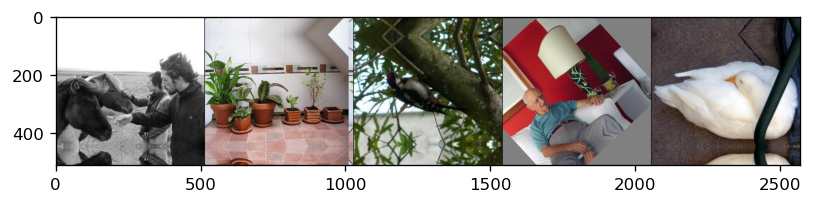

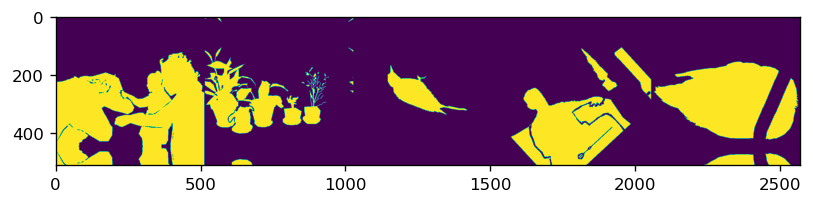

In [128]:
def show_dataset(dataset):
    images = []
    masks = []
    for _ in range(5):
        i = random.randint(0, len(valset) - 1)
        if len(images):
            separator = np.zeros((dataset.image_size[0], 2, 3), dtype=np.uint8)
            images.append(separator)
            masks.append(separator[:, :, 0])
        image, mask = dataset[i]
        images.append(image_to_numpy(image))
        masks.append(image_to_numpy(mask[None, ...])[..., 0])

    %matplotlib inline
    set_figure_size()
    plt.imshow(np.concatenate(images, axis=1))
    plt.show()
    set_figure_size()
    plt.imshow(np.concatenate(masks, axis=1))
    plt.show()
    
valset.set_padding(0)
show_dataset(trainset)

Кстати тут видно и мои аугментации, первая это to_gray, вторая сдвиг, и 4 поворот

In [129]:
from torch.utils.data import DataLoader

In [130]:
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

### Model

In [131]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from timm.scheduler import TanhLRScheduler
from pytorch_lightning.callbacks import LearningRateMonitor

In [132]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0]:offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0]:offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1]:offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1]:offset[1] + wi]
    return predicted, images

In [133]:
class BCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._bce = torch.nn.BCEWithLogitsLoss()
                
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError("{} не подходит для многоклассовой классификации".format(type(self)))
            
        # predicted: float32, BCHW.
        # masks: long, BHW.

        loss = self._bce(predicted.squeeze(1), masks.float())        
        return loss

#### Добавим метркики и лоссы

In [135]:
class meanIoU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)  
        predicted = [i.detach().cpu().apply_(lambda x: int(x >= 0.5)).to(torch.long) for i in predicted]      
        results = []
        for pred, mask in zip(predicted, masks):
            pred = pred.to(DEVICE)
            results.append(torch.sum(pred & mask).item() / torch.sum(pred | mask).item())
        return np.mean(results)

class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
 
    def __call__(self, input, target):
        N = target.size(0)
        smooth = 1
 
        input_flat = input.view(N, -1)
        target_flat = target.view(N, -1)
 
        intersection = input_flat * target_flat
 
        loss = 2 * (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
        loss = 1 - loss.sum() / N
 
        return loss


class JaccardLoss(torch.nn.Module):
    def __init__(self):
        super(JaccardLoss, self).__init__()
        
    def __call__(self, predicted, masks):
        smooth = 100
        intersection= (predicted * masks).abs().sum()
        sum_ = torch.sum(predicted.abs() + masks.abs())
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth
    
 
    

In [136]:
from torchvision.models.segmentation import deeplabv3_resnet50

In [137]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
                
        self.model = deeplabv3_resnet50(weights=None)
        self.model.classifier[-1] = torch.nn.Sequential(torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1)),
                                                       torch.nn.Sigmoid())
        
        self.iou = meanIoU()

        self.bce_loss = BCELoss()
        self.second_loss = DiceLoss()
        self.criterion = lambda preds, masks: (self.bce_loss(preds, masks) + self.second_loss(preds, masks)) #BCELoss()
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        torch.cuda.empty_cache()

        images, masks = batch
        preds = self.model(images)
        loss = self.criterion(preds['out'], masks)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        torch.cuda.empty_cache()

        images, masks = batch
        preds = self.model(images)
        loss = self.criterion(preds['out'], masks)
        self.log("validation_loss", loss, sync_dist=True)
        # IoU metric
        self.log("validation_IoU", self.iou(preds['out'], masks), sync_dist=True)
        
    def forward(self, images):
        torch.cuda.empty_cache()

        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        #preds = [i.detach().cpu().apply_(lambda x: int(x >= 0.5)).to(torch.long) for i in preds['out']]
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return [optimizer]

In [138]:
# model
pl_model = SegmentationModel(3e-4)
checkpoint_callback = ModelCheckpoint(monitor='validation_IoU',mode='max',  save_top_k=3)
last_checkpoint = ModelCheckpoint(mode='max', monitor='time_log', save_top_k=1)

early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(max_epochs = 5, accelerator=DEVICE, devices = 1, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

In [139]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [140]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_IoU       │    0.5040950775042753     │
│      validation_loss      │    1.0535166263580322     │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 1.0535166263580322, 'validation_IoU': 0.5040950775042753}]

In [141]:
# model = deeplabv3_resnet50(weights=None)
# model.classifier[-1] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# images, masks = next(iter(train_loader))
# print(images.shape, masks.shape)

# torch.cuda.empty_cache()

# model.to(DEVICE)
# pred = model(images.to(DEVICE))

In [142]:
def show_segmentations(model, dataset, n=5):
    model.eval()
    if USE_CUDA:
        model.cuda()
    for _ in range(n):
        image, mask_gt = dataset[random.randint(0, len(dataset) - 1)]
        if USE_CUDA:
            image = image.cuda()
            mask_gt = mask_gt.cuda()
        with torch.no_grad():
            predicted = model(image.unsqueeze(0))['out'][0]  # CHW.
            predicted, image = crop_images(predicted.unsqueeze(0), image.unsqueeze(0))
            predicted, image = predicted[0], image[0]
            c = predicted.shape[0]
            if c == 1:
                predicted = torch.nn.functional.logsigmoid(predicted)
                aggregated = predicted[0]
                predicted_labels = predicted[0] > np.log(0.5)
            else:
                predicted = torch.nn.functional.log_softmax(predicted, 0)
                aggregated = torch.logsumexp(predicted[1:], axis=0)
                predicted_labels = predicted.max(0)[1]
        aggregated = aggregated.cpu().numpy()
        predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
        image = image_to_numpy(image)
        mask = (predicted_labels > 0)[..., None]
        selected = image * mask + 255 * (1 - mask)

        %matplotlib inline
        if c != 1:
            print("Classes:", [LABELS[i] for i in set(predicted_labels.flatten().tolist())])
        set_figure_size()
        fig, axs = plt.subplots(1, 4, figsize=(12, 6))
        axs[0].imshow(image)
        axs[1].imshow(predicted_labels)
        axs[2].imshow(aggregated)
        axs[3].imshow(selected)
        plt.show()

<Figure size 960x720 with 0 Axes>

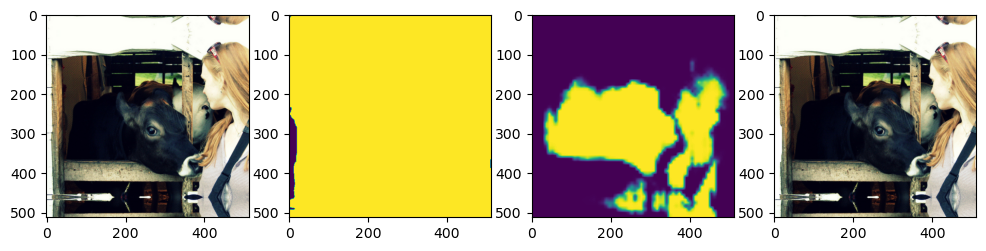

<Figure size 960x720 with 0 Axes>

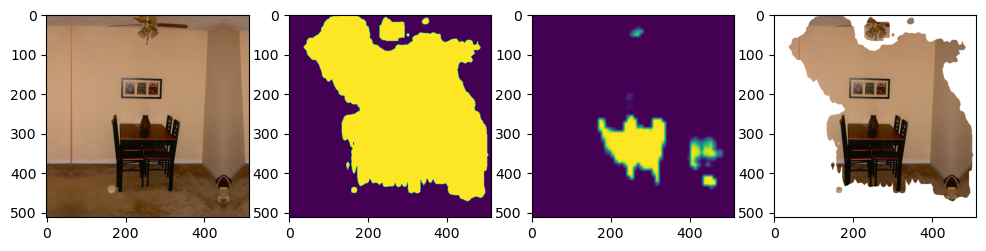

<Figure size 960x720 with 0 Axes>

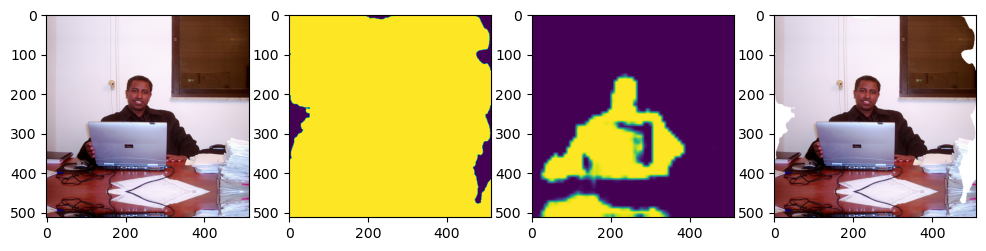

<Figure size 960x720 with 0 Axes>

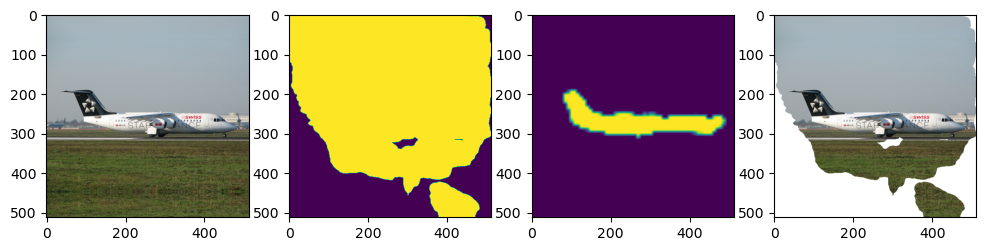

<Figure size 960x720 with 0 Axes>

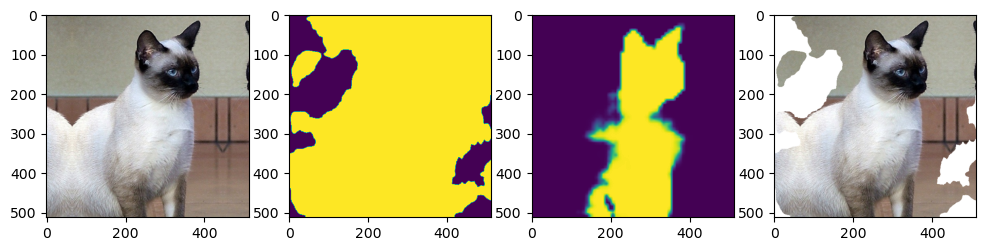

In [143]:
show_segmentations(pl_model, valset)

#### В целом видно, что она обучается, она очень старается)) Но понятно, что такая тяжеленькая архитектура идельно не обучится у меня в колабе на одной гпу несчастной...